In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

2025-05-20 16:42:59.455984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747759379.474983 3743541 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747759379.480813 3743541 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 16:42:59.502794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preprocessing

In [5]:
train = pd.read_csv("train.csv")
val = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

#Eliminamos la primera columna, generada al pasar el conjunto de datos a formato csv.
train=train.drop(columns='Unnamed: 0')
val=val.drop(columns='Unnamed: 0')
test=test.drop(columns='Unnamed: 0')

train['proto'] = train['proto'].map({'TCP': 0, 'UDP': 1})
val['proto'] = val['proto'].map({'TCP': 0, 'UDP': 1})
test['proto'] = test['proto'].map({'TCP': 0, 'UDP': 1})

In [4]:
# Grouping the variable push flag into 10 bins
bins = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [i for i in range(len(bins)-1)]

train['ip.flags.df'] = pd.cut(train['ip.flags.df'], bins=bins, labels=labels, right=True, include_lowest=True)
val['ip.flags.df'] = pd.cut(val['ip.flags.df'], bins=bins, labels=labels, right=True, include_lowest=True)
test['ip.flags.df'] = pd.cut(test['ip.flags.df'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.res'] = pd.cut(train['tcp.flags.res'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.res'] = pd.cut(val['tcp.flags.res'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.res'] = pd.cut(test['tcp.flags.res'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.cwr'] = pd.cut(train['tcp.flags.cwr'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.cwr'] = pd.cut(val['tcp.flags.cwr'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.cwr'] = pd.cut(test['tcp.flags.cwr'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.ecn'] = pd.cut(train['tcp.flags.ecn'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.ecn'] = pd.cut(val['tcp.flags.ecn'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.ecn'] = pd.cut(test['tcp.flags.ecn'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.urg'] = pd.cut(train['tcp.flags.urg'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.urg'] = pd.cut(val['tcp.flags.urg'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.urg'] = pd.cut(test['tcp.flags.urg'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.ack'] = pd.cut(train['tcp.flags.ack'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.ack'] = pd.cut(val['tcp.flags.ack'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.ack'] = pd.cut(test['tcp.flags.ack'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.reset'] = pd.cut(train['tcp.flags.reset'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.reset'] = pd.cut(val['tcp.flags.reset'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.reset'] = pd.cut(test['tcp.flags.reset'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.syn'] = pd.cut(train['tcp.flags.syn'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.syn'] = pd.cut(val['tcp.flags.syn'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.syn'] = pd.cut(test['tcp.flags.syn'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.push'] = pd.cut(train['tcp.flags.push'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.push'] = pd.cut(val['tcp.flags.push'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.push'] = pd.cut(test['tcp.flags.push'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.fin'] = pd.cut(train['tcp.flags.fin'], bins=bins, labels=labels, right=True, include_lowest=True)
val['tcp.flags.fin'] = pd.cut(val['tcp.flags.fin'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.fin'] = pd.cut(test['tcp.flags.fin'], bins=bins, labels=labels, right=True, include_lowest=True)

In [4]:
porcentaje_mantener = 0.001

train_reducido_udp = train[train['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

train = pd.concat([train_reducido_udp, train_reducido_tcp])


test_reducido_udp = test[test['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

test = pd.concat([test_reducido_udp, test_reducido_tcp])

In [4]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de entrenamiento
X_test = test.drop(columns=['category'])
y_test = test['category']

X_val = val.drop(columns=['category'])
y_val = val['category']

## Full-Feature Model Evaluation

In [5]:
X_train.shape, X_test.shape, X_val.shape

((1117830, 56), (319400, 56), (159690, 56))

In [6]:
# Normalización del conjunto de datos
norm = StandardScaler()

X_train = norm.fit_transform(X_train)
X_val = norm.fit_transform(X_val)
X_test = norm.fit_transform(X_test)

#Codificacion de etiquetas (Numéricas)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Convertir las etiquetas codificadas a codificación one-hot (10 columnas por muestras)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=10)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=10)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=10)

In [7]:
model_filepath = 'Model56Feat/model3-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    #verbose = 1
)

In [8]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch = 1000
steps_per_epoch = len(X_train) // batch
validation_steps = len(X_val) // batch

# Entrenar el modelo
history = model.fit(X_train,
                    y_train_one_hot,
                    epochs=1000, batch_size=batch,
                    validation_data=(X_val, y_val_one_hot),
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks=[checkpoint])


/home/iraizozj/entorno/entorno/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745593282.824319 2299159 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38484 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
I0000 00:00:1745593282.825972 2299159 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38484 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1745593282.827833 2299159 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38484 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40G

Epoch 1/1000


I0000 00:00:1745593285.490687 2299645 service.cc:148] XLA service 0x7f66c400d1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745593285.490714 2299645 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1745593285.490719 2299645 service.cc:156]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1745593285.490722 2299645 service.cc:156]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1745593285.490725 2299645 service.cc:156]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-25 15:01:25.539463: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745593285.683519 2299645 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-25 15:01:27.405906: I external/local_xla

  86/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5188 - loss: 1.2864

I0000 00:00:1745593289.805707 2299645 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1099/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6400 - loss: 0.8261

2025-04-25 15:01:33.159901: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 296 bytes spill stores, 296 bytes spill loads

2025-04-25 15:01:33.221591: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58_0', 776 bytes spill stores, 464 bytes spill loads

2025-04-25 15:01:33.358770: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 136 bytes spill stores, 136 bytes spill loads

2025-04-25 15:01:33.396171: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 136 bytes spill stores, 136 bytes spill loads

2025-04-25 15:01:33.434626: I external/local_xla/xla/strea

1117/1117 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6406 - loss: 0.8244 - val_accuracy: 0.7042 - val_loss: 0.6527
Epoch 2/1000


2025-04-25 15:01:35.736253: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1123', 20 bytes spill stores, 20 bytes spill loads

2025-04-25 15:01:35.823452: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1123', 140 bytes spill stores, 140 bytes spill loads

2025-04-25 15:01:35.860938: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1123_0', 4 bytes spill stores, 4 bytes spill loads

2025-04-25 15:01:35.903771: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_217', 216 bytes spill stores, 216 bytes spill loads

2025-04-25 15:01:35.915812: I external/local_xla/xla/stre

   1/1117 ━━━━━━━━━━━━━━━━━━━━ 1:09:45 4s/step - accuracy: 0.7422 - loss: 0.5920

/home/iraizozj/entorno/entorno/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1117/1117 ━━━━━━━━━━━━━━━━━━━━ 4s 334us/step - accuracy: 0.7422 - loss: 0.5920 - val_accuracy: 0.7046 - val_loss: 0.6541
Epoch 3/1000
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7071 - loss: 0.6471 - val_accuracy: 0.7206 - val_loss: 0.6213
Epoch 4/1000
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.7000 - loss: 0.6430 - val_accuracy: 0.7208 - val_loss: 0.6225
Epoch 5/1000
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7241 - loss: 0.6081 - val_accuracy: 0.7312 - val_loss: 0.5947
Epoch 6/1000
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - accuracy: 0.7157 - loss: 0.6275 - val_accuracy: 0.7344 - val_loss: 0.5917
Epoch 7/1000
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7353 - loss: 0.5830 - val_accuracy: 0.7459 - val_loss: 0.5680
Epoch 8/1000
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.7530 - loss: 0.5308 - val_accuracy: 0.7464 - val_loss: 0.5694
Epoch 9/1000
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7431 - loss

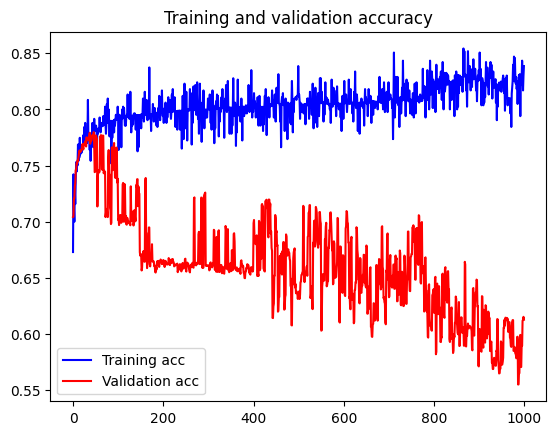

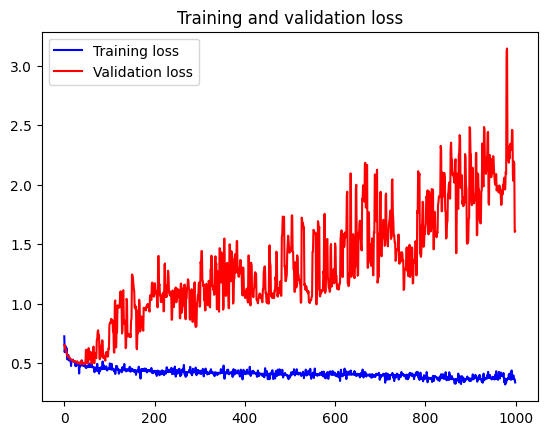

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

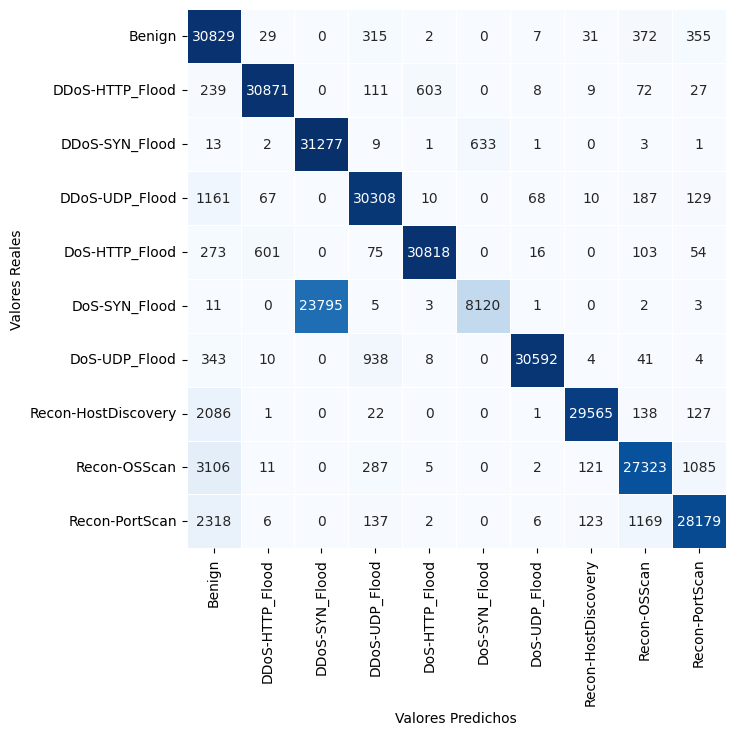

In [9]:
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

# Dropping Constant and Quasi-constant features

## First method

We consider the feature as a quasi-constant feature, if the predominant value has more than X % of the observations

In [10]:
quasi_constant_feat = []

for feature in X_train.columns:
    
    predominant = X_train[feature].value_counts(normalize=True).values[0]
    
    # 
    if predominant > 0.998:
        quasi_constant_feat.append(feature)
        
len(quasi_constant_feat)
    

12

In [11]:
quasi_constant_feat

['ip.flags.rb',
 'ip.flags.mf',
 'tcp.flags.res',
 'tcp.flags.ns',
 'tcp.flags.cwr',
 'tcp.flags.ecn',
 'tcp.flags.urg',
 'ip.checksum.status.min',
 'l4.checksum.status.std',
 'l4.checksum.status.min',
 'l4.checksum.status.max',
 'l4.checksum.status.mean']

In [12]:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((1117830, 44), (319400, 44))

## Second Method

We consider the feature as a quasi-constant feature if the variance of the feature is over 0.01

In [13]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(X_train)

VarianceThreshold(threshold=0.01)

In [14]:
quasi_constant = X_train.columns[~sel.get_support()]

len(quasi_constant)

3

In [15]:
features = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

X_train.shape, X_test.shape

((1117830, 41), (319400, 41))

## Dropping Duplicated Features

There aren't any 

In [25]:
sel = DropDuplicateFeatures(variables=None, missing_values='raise')
sel.fit(X_train)
sel.duplicated_feature_sets_

[]

# Correlated Features

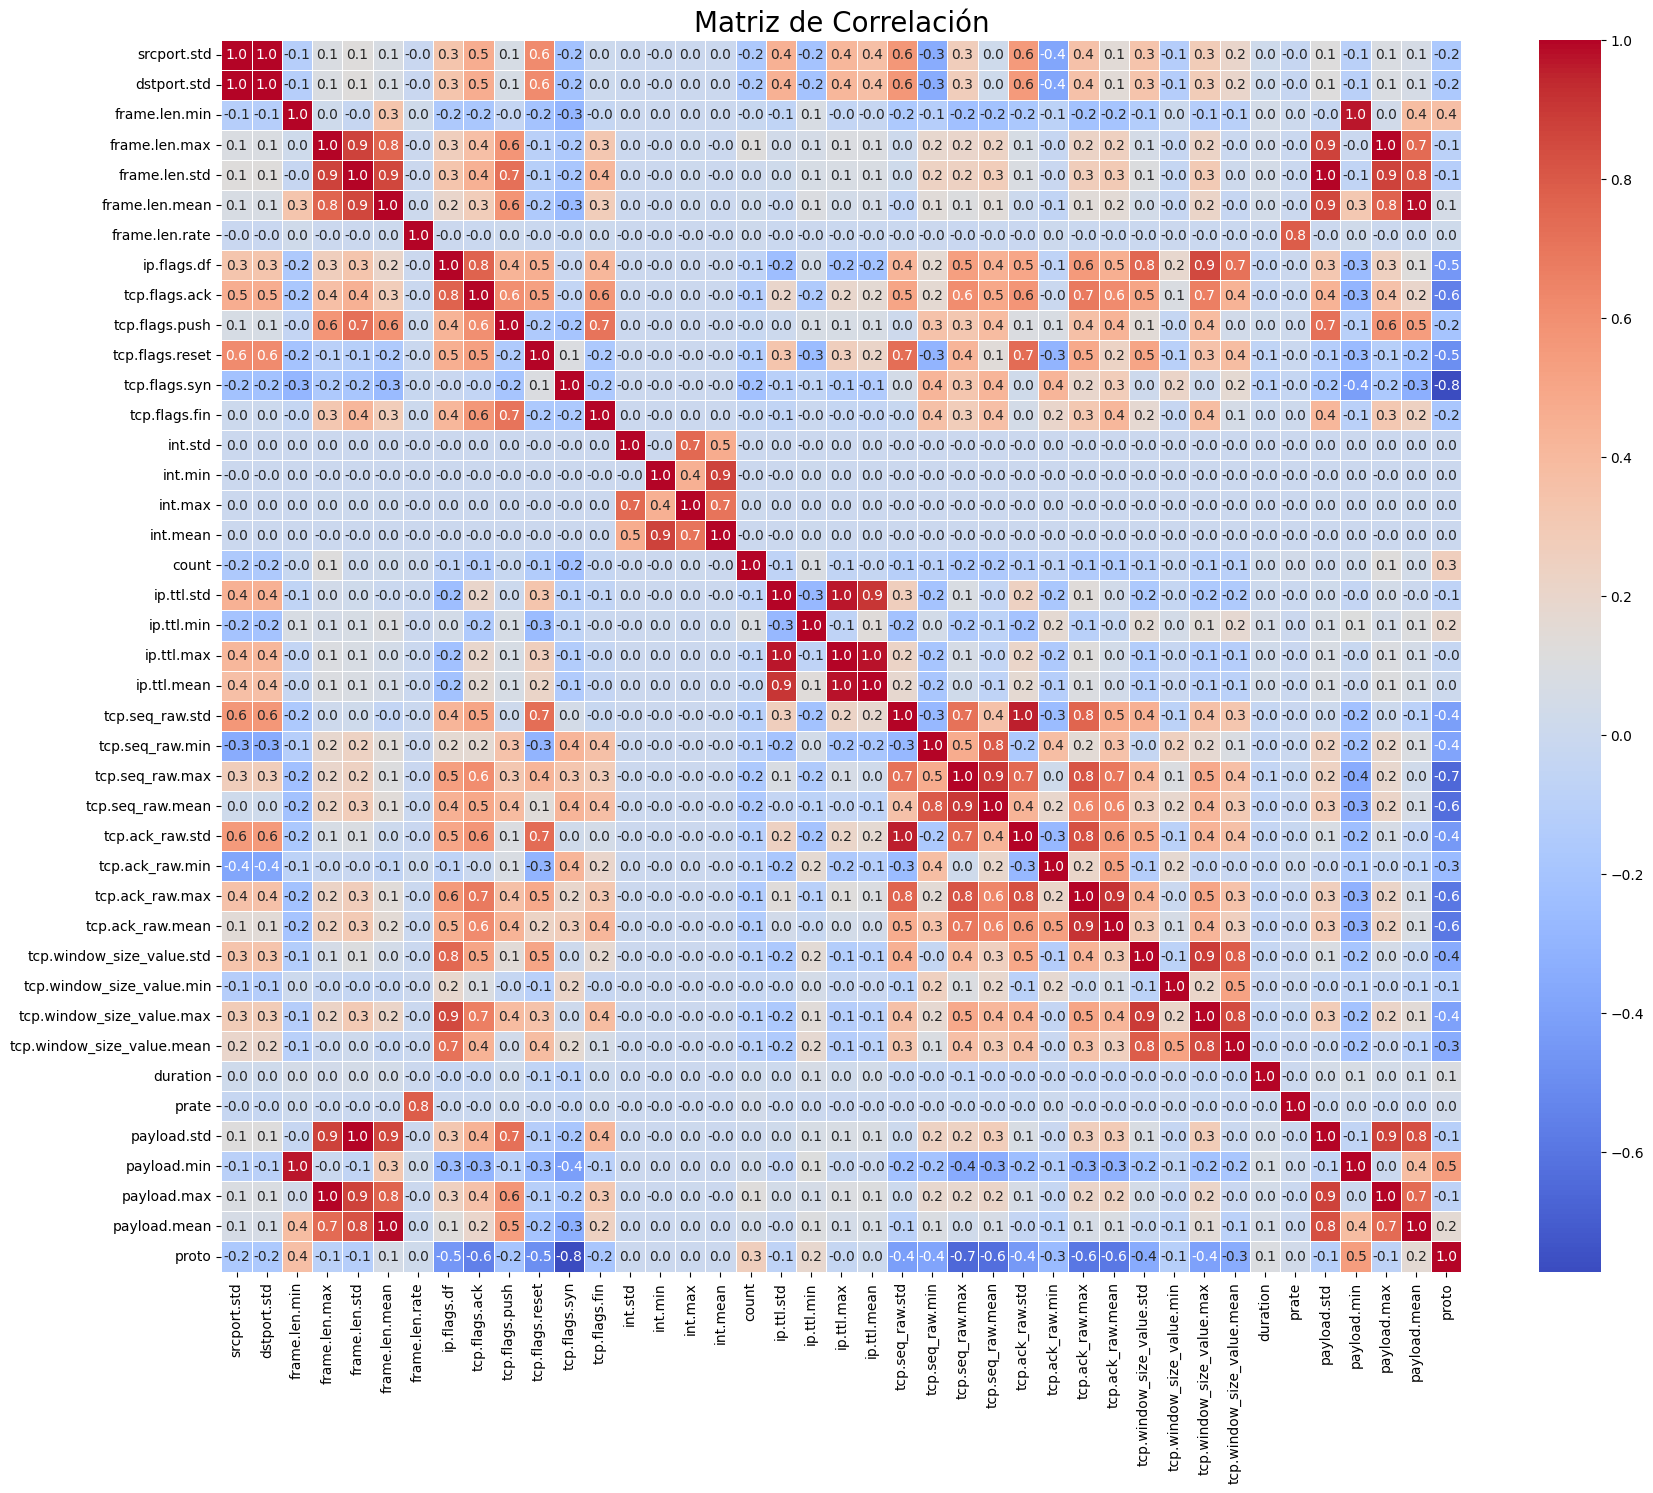

In [26]:
import numpy as np
corr_matrix = X_train.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".1f")
plt.title("Matriz de Correlación", fontsize=20)
plt.show()


## Method 1 : Brute Force

In [16]:
def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns. Sets cannot contain duplicated elements
    col_corr = set()
    
    # create the correlation matrix
    corr_matrix = dataset.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corr_matrix.columns)):
        
        # check with other features (Not with itself)
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

In [17]:
corr_features = correlation(X_train, 0.90)
len(set(corr_features))

1.0 dstport.std srcport.std
0.9720460527354214 ip.ttl.max ip.ttl.std
0.9094681371010614 ip.ttl.mean ip.ttl.std
0.9764186145265968 ip.ttl.mean ip.ttl.max
0.9028231538344306 tcp.seq_raw.mean tcp.seq_raw.max
0.9532631167078506 tcp.ack_raw.std tcp.seq_raw.std
0.9124857948600464 tcp.ack_raw.mean tcp.ack_raw.max
0.9996532465954793 payload.std frame.len.std
0.9717974434019288 payload.min frame.len.min
0.9998232656437477 payload.max frame.len.max
0.992985277931503 payload.mean frame.len.mean


10

## We'll Drop the redundant features 

In [18]:
corr_features = ['srcport.std', 'ip.ttl.std','ip.ttl.mean', 'frame.len.mean', 'frame.len.max', 'frame.len.min', 'frame.len.std', 'tcp.ack_raw.std']

In [19]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((1117830, 33), (319400, 33))

In [20]:
train = pd.concat([X_train, y_train], axis=1).to_csv('train_B.csv', index=False)
test = pd.concat([X_test, y_test], axis=1).to_csv('test_B.csv', index=False)

In [21]:
train = pd.read_csv("train_B.csv")
test = pd.read_csv("test_B.csv")

In [22]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de entrenamiento
X_test = test.drop(columns=['category'])
y_test = test['category']

In [23]:
RF = RandomForestClassifier()

param_grid = {'max_depth': [18]} 
grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

print('Best Cross Validation Score:', grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Cross Validation Score: 0.8428965048352612


In [24]:
RF =  grid.best_estimator_

print('Train Score:', RF.score(X_train, y_train))

y_pred = RF.predict(X_test)

start2=time.time()
print('Precision en test: ', accuracy_score(y_test, y_pred))
stop2=time.time()

tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) RF: {tiempo2}s")

Train Score: 0.88265568109641
Precision en test:  0.8696524733876018
Tiempo de prediccion (Test) RF: 0.2830970287322998s


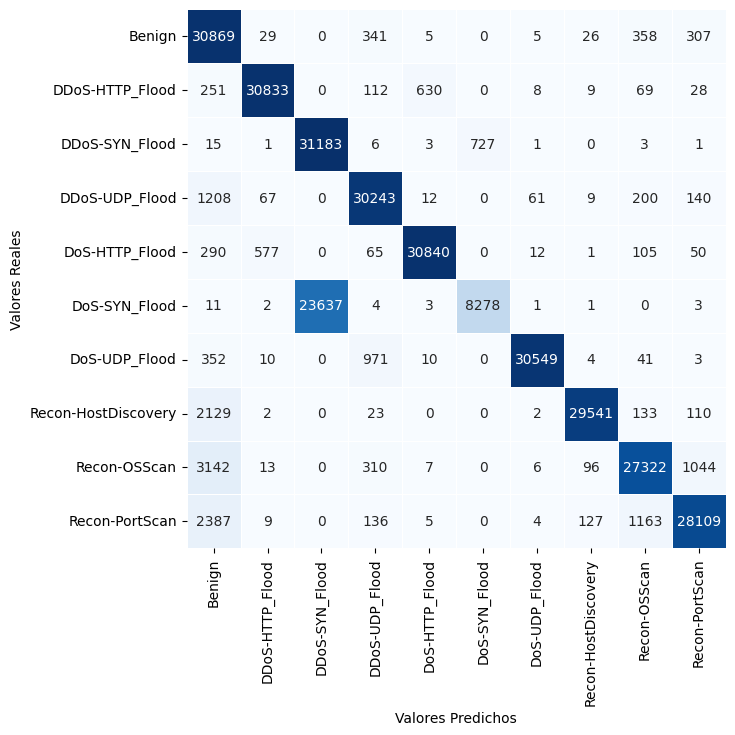

In [25]:
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [26]:
import joblib
joblib.dump(RF, 'RF_model1.pkl')

['RF_model1.pkl']